In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast
import os
import sys
import pymc as pm
import pandas as pd

from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'lib'))
print("Lib path:", lib_path)

# Append the absolute path to sys.path
sys.path.append(lib_path)

# Now, try importing onedmodel
from onedmodel import *

Lib path: /Users/guime/projects/SLTforSGD/code/lib


In [3]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

## Plot fraction of trajectories when stuck in 1D

In [6]:
# Initialise
nSGD = 10**3
nsamples = 10**6
shuffle = True
batch_size= 20
lr = 0.01
w0 = 1.8
seed_init = 1
seed_data = 1
nw0 = 2
d1 = 2
d2 = 3
wmax = nw0 * w0
frac_max = 10**-3
model = PolyModel(w0=w0, seed=seed_init, wmax=wmax, wmin=-wmax, d1=d1,d2=d2)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories(model)

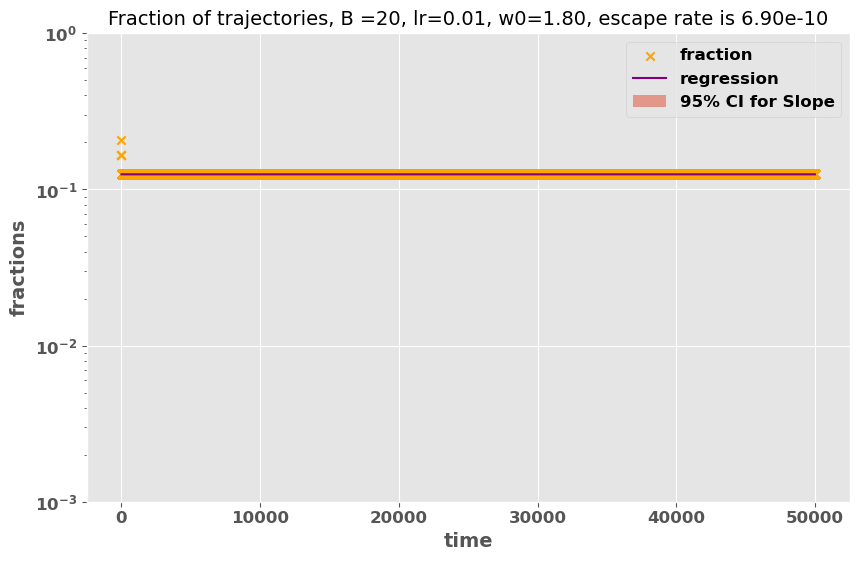

In [7]:
%matplotlib inline
trajectories = np.asarray(df['trajectory'].to_list())
clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
fraction = regular_fraction(clean_traj, model)
escape_rate, error = compute_escape_rate(fraction, frac_max=frac_max, tmin=3,
                            batch_size=batch_size, lr=0.01, w0=w0)

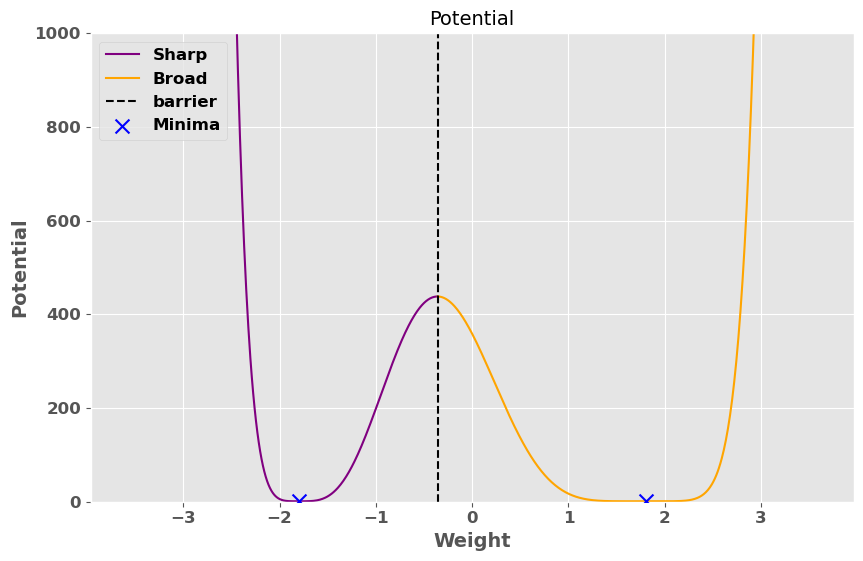

In [9]:
plot_potential(model, nsamp = 10**4, ymax = 1000)

Text(0.5, 1.0, 'Distribution of SGD trajectories after 50000.0 iterations')

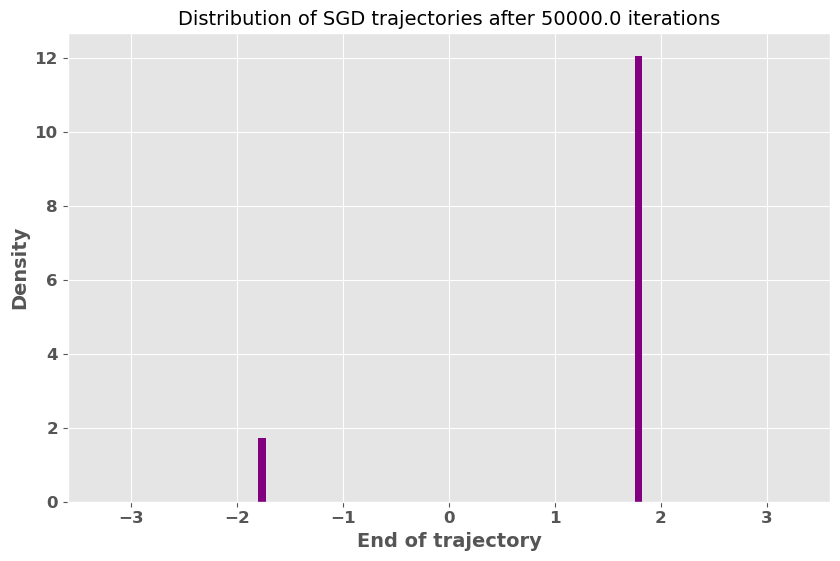

In [11]:
wf = []
for i in range(len(df)):
    wf.append(df["trajectory"][i][-1])
niterations = nsamples/batch_size
plt.hist(wf, bins=50, density=True, color="purple")
plt.xlabel("End of trajectory")
plt.ylabel("Density")
plt.xlim((-wmax, wmax))
plt.title(f"Distribution of SGD trajectories after {niterations} iterations")

## Plot 1D posterior

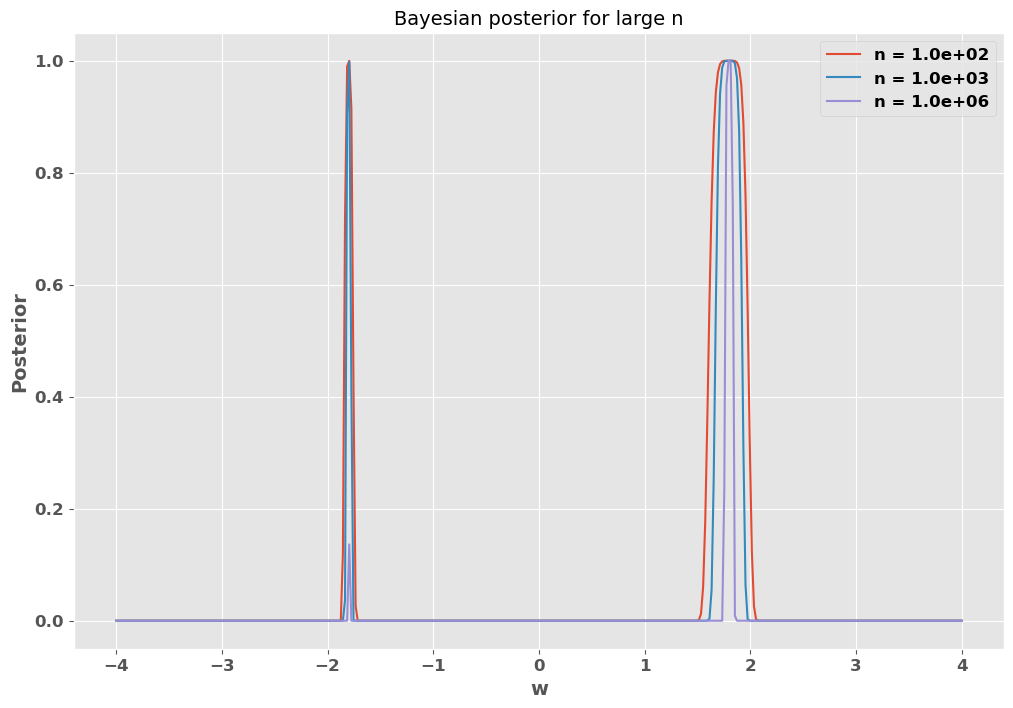

In [19]:
# Exact
n_values = [100, 1000, 1000000]

w = np.linspace(-4, 4, 400)
K_w = (w - w0)**6 * (w + w0)**4
# Plotting the function for different values of n
plt.figure(figsize=(12, 8))

for n in n_values:
    l = np.exp(-n*K_w)
    plt.plot(w, l, label=f'n = {n:.1e}')
plt.title('Bayesian posterior for large n')
plt.xlabel('w')
plt.ylabel('Posterior')
plt.legend()
plt.grid(True)
plt.yscale("linear")  # Using a logarithmic scale for better visualization
plt.show()


## Plot trajectories when stuck in 2D

In [17]:
# Initialise
nSGD = 10**3
nsamples = 10**5
shuffle = True
batch_size= 20
lr = 0.01
seed_init = 1
seed_data = 1
wxm = 0
wym = 4
d=2
wx_init = torch.tensor(0.0) 
wy_init = torch.tensor(-10.0)
model = PolyModel2D(seed=seed_init, wxm=wxm, wym=wym, wx_init=wx_init, wy_init = wy_init, d=d)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories2d(model)

4


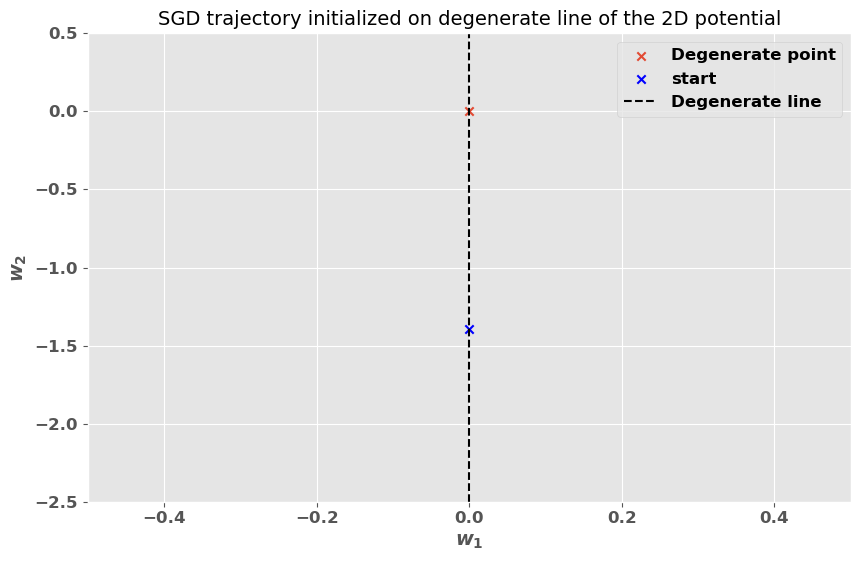

In [14]:
%matplotlib inline
wx = df["trajectory1"][0]
wy = df["trajectory2"][0]
print(len(wx))
fig, ax = plt.subplots()
plt.plot(wx,wy, color='purple')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.xlim((-0.5, 0.5))
plt.ylim((-2.5, 0.5))
plt.grid(True)
plt.scatter(0,0,marker='x', label="Degenerate point")
plt.scatter(wx[0], wy[0], marker='x', label="start", color='blue')
plt.axvline(x=0, linestyle='--',label = "Degenerate line", color='k')
plt.title("SGD trajectory initialized on degenerate line of the 2D potential")
plt.legend()
plt.show()

In [15]:
# Histogram of SGD trajectories over the degenerate line
wyf = [0]*nSGD
for i in range(nSGD):
    wyf[i] = df["trajectory2"][i][-1]

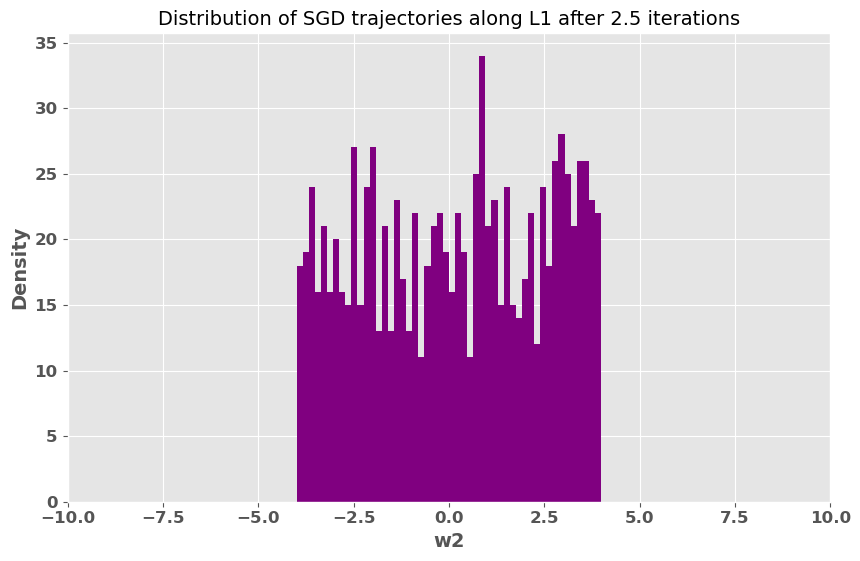

In [16]:
%matplotlib inline
niterations = nsamples/batch_size
plt.hist(wyf, bins=50, color='purple')
plt.xlabel("w2")
plt.ylabel("Density")
plt.xlim((-wym, wym))
plt.title(f"Distribution of SGD trajectories along L1 after {niterations} iterations")
plt.show()

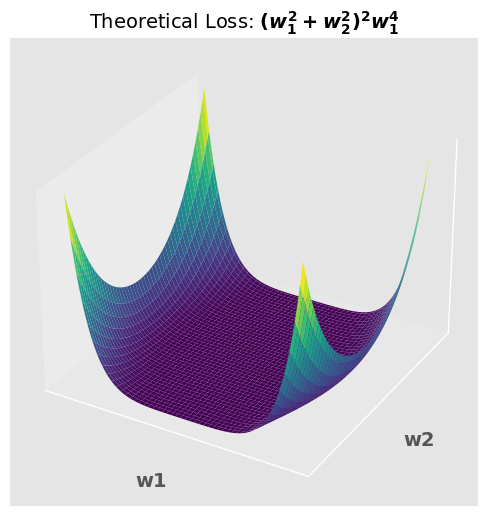

In [26]:
# 2D potential
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(w1, w2)

# Calculate the loss function values
k = (wx**2 + wy**2)**2 * wx**4

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(wx, wy, k, cmap='viridis')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title(r'Theoretical Loss: $(w_1^2 + w_2^2)^2w_1^4$')

# Display the plot
plt.show()

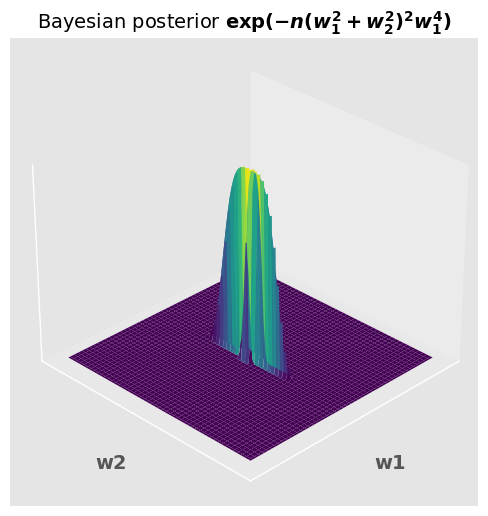

In [41]:
# 2D posterior
from mpl_toolkits.mplot3d import Axes3D

n = nsamples*100000
# Create a grid of points
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(w1, w2)

# Calculate the loss function values
k = (wx**2 + wy**2)**2 * wx**4
post = np.exp(-n*k)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(wx, wy, post, cmap='viridis')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title(r'Bayesian posterior $\exp(-n(w_1^2 + w_2^2)^2w_1^4)$')

# Display the plot
# Set the initial viewing angle
elev = 30  # Elevation angle in degrees
azim = 45  # Azimuth angle in degrees
ax.view_init(elev=elev, azim=azim)

# Display the plot
plt.show()

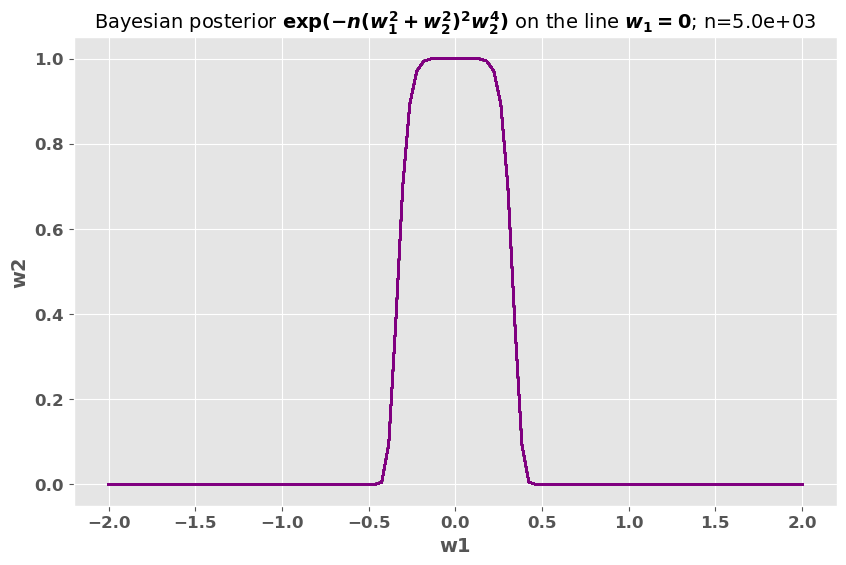

In [105]:
# 2D posterior
from mpl_toolkits.mplot3d import Axes3D

n = niterations
# Create a grid of points
w1 = np.linspace(-2, 2, 100)
w2 = np.linspace(-2, 2, 100)
wx, wy = np.meshgrid(w1, w2)

# Calculate the loss function values
wx = 0
k = (wx**2 + wy**2)**2 * wy**4
post = np.exp(-n*k)
# Create a 3D plot
fig = plt.figure()
plt.plot(wy, post, color="purple")
plt.xlabel('w2')
plt.ylabel('Probability density')
plt.title(rf'Bayesian posterior $\exp(-n(w_1^2 + w_2^2)^2w_2^4)$ on the line $w_1=0$; n={n:.1e}')
# Display the plot
plt.show()